# ECON 570: Final Project

# Evaluation of Job Training Program with Nonexperimental Data

Masashi Yoshioka (3200-3439-52), Jincen Jiang (XXXX-XXXX-XX), Shuxian Mao (XXXX-XXXX-XX)

In [1]:
# Suppress warnings
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import pyreadr
import random
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression as lr
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.iolib.summary2 import summary_col
from utils.functions import *

np.random.seed(570)
random.seed(570)

C:\Users\imym0\Anaconda3\envs\finance\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## 1. Introduction

a. What question are you answering with your project?  
b. Why should we care about this question?  
c. Have there been previous papers in the economics literature addressing this question? Summarize previous research briefly.

Draft by Shuxian:

There are three main papers use data from the National Supported Work Demonstration experiment to study the performance of econometric estimators.

Lalonde (1986) first uses data from a randomized evaluation program. He investigated the extent to which non-experimental estimates can replicate unbiased experimental estimates of treatment effects when applied to a combined dataset of experimental treatment units and non-experimental comparison units. He concluded that standard non-experimental estimation methods, such as regression, fixed effects, and potential variable selection models, are either inaccurate relative to experimental benchmarks or sensitive to the specifications used in regression.

On the other hand, Dehejia and Wahba (1999) demonstrate the estimates of the training effect for Lalonde's hybrid of an experimental and non-experimental dataset are close to the benchmark experimental estimate when using propensity score methods. They conclude that although the method cannot account some important unobservable covariates, there are still substantial rewards in exploring first the information contained in the variables that are observed.

However, when Smith and Todd (2005) applied the same methods to other reasonable samples from the NSW data which is different from DW used, the low bias results disappear. They discovered that the NSW impact estimates based on propensity score matching were very sensitive to both the variables included in the scores and the particular sample of analyses used in the estimates. They also found that the difference-in-difference match estimator performed best among cross-sectional matching, propensity score matching, and difference-in-difference estimation in all of their studies. Their findings show that while propensity score matching is a potentially useful econometric tool, it does not represent a general solution to the evaluation problem.

## 2. Data

a. Describe the source(s) of the data  
b. Discuss whether you are removing any outliers from your data, or doing any other sampling restrictions  
c. Discuss whether you are transforming the data and/or merging/appending multiple datasets together  
d. Show comprehensive summary statistics.  
Remember: summary statistics are a very important part of all applied work!

### 2.1 The National Supported Work Demonstration

We use a dataset from the National Supported Work (NSW) Demonstration, which has been commonly used in the causal inference literature, including LaLonde (1986), Dehejia and Wahba (1999) and Smith and Todd (2005) as explained above. 

The NSW was a job training program conducted in the mid-1970s at 15 sites around the United States. Our dataset is focused on the program implemented in 10 sites from April 1975 to August 1977 among others. The program was targeted at 4 types of hard-to-employ people: female long-term AFDC<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) recipients, ex-drug addicts, ex-climinal offenders and high school dropouts. The potential participants had to satisfy a set of eligibility criteria that included: (i) they must have been currently unemployed, (ii) they must have spent no more than 3 months on one regular job of at least 20 hours per week during the preceding 6 months, and so forth. These criteria as well as self-selection made the participants in NSW differ from the U.S. population in many characteristics.

The program operated as a randomized experiment by randomly assigning some applicants to a control group that was not allowed to participate in the program. For those assigned to the treatment group, the program guaranteed a job for 9 to 18 months, depending on the target group and site. The program paid the treatment group for their work, but the offered wage was lower than they would have received on a regular job. The participants were forced to find a regular job after their terms in the program expired.

The treatment and control groups were interviewed five times in total, one of which was a baseline and the others were follow-ups. Many people failed to complete these interviews and thus the sample attrition could have possibly caused biases. However, LaLonde (1986) suggests that the largest source of attrition, which is the interview schedule according to LaLonde (1986), should not affect the integrity of the experimental design because the interviews were randomly scheduled. Here we just assume that LaLonde (1986) is right and will not deal with the potential sample attrition problem. The interviews provide information on demographic characteristics, employment history, household income and so forth.

We are interested in the effect of the NSW on earnings of participants. Since the program randomly assigned applicants to treatment and control groups, the experimental data would presumably give us an unbiased estimate for the average treatment effect (ATE) of the program. LaLonde (1986) compared the experimental data with nonexperimental data such as Current Population Survey (CPS) and Panel Study of Income Dynamics (PSID), concluding that nonexperimental data fail to generate similar results to experimental data. Dehejia and Wahba (1999) concentrate on subsamples whose earnings in 1974 are available, and conclude that propensity-score matching would generate the results close to experimental design. Thus, our dataset consists of 6 different groups of samples: treatment group in LaLonde (1986), control group in LaLonde (1986), treatment subgroup in Dehejia and Wahba (1999), control subgroup in Dehejia and Wahba (1999), nonexperimental data from CPS and those from PSID. Using the dataset, we will see if nonexperimental data can generate estimates that are close enough to those given by experimental data.

### 2.2 Sample Restrictions

The datasets were retrieved from https://github.com/jjchern/lalonde/tree/master/data on February 2, 2022. Note that it only includes the male samples due to the data availability of LaLonde (1986). That is why Dehejia and Wahba (1999) and Smith and Todd (2005) also focus on males. This repository also includes the subsamples of CPS and PSID that were chosen by LaLonde (1986) to make them resemble the NSW applicants to the extent possible. However, according to Dehejia and Wahba (1999), choosing subsamples arbitrarily from the nonexperimental data would not improve the estimate. Thus, we will use the 6 groups described in 2.1 and discard subsamples of CPS and PSID. For the same reason, we will not do any sample restrictions including removing outliers from the data. Since the experiment was randomized, using all the samples would give an unbiased estimate of ATE. On the other hand, arbitrary sample restrictions can make treatment and control groups incomparable, which could cause a bias in the estimate.

### 2.3 Summary Statistics

First of all, we describe the summary statistics of each group below. The data includes the treatment status (`treat`), age (`age`), years of education (`education`), dummy for black (`black`), dummy for hispanic (`hispanic`), dummy for being married (`married`), dummy for dropout (`nodegree`), earnings in 1975 (`re75`) and in 1978 (`re78`). Note that the earnings in 1974 (`re74`) were not available for LaLonde (1986) experimental samples.

#### 2.3.1 LaLonde (1986) Experimental Data

In [3]:
# LaLonde's original dataset
df_nsw = pyreadr.read_r('./data/nsw.rda')['nsw']
df_nsw.head()

data_id  treat   age  education  black  hispanic  married  nodegree  \
0  Lalonde Sample    1.0  37.0       11.0    1.0       0.0      1.0       1.0   
1  Lalonde Sample    1.0  22.0        9.0    0.0       1.0      0.0       1.0   
2  Lalonde Sample    1.0  30.0       12.0    1.0       0.0      0.0       0.0   
3  Lalonde Sample    1.0  27.0       11.0    1.0       0.0      0.0       1.0   
4  Lalonde Sample    1.0  33.0        8.0    1.0       0.0      0.0       1.0   

   re75          re78  
0   0.0   9930.045898  
1   0.0   3595.894043  
2   0.0  24909.449219  
3   0.0   7506.145996  
4   0.0    289.789886

In [4]:
# Treatment group in LaLonde (1986)
print('LaLonde treatment group')
df_nsw[df_nsw['treat'] == 1].describe().T

LaLonde treatment group


count         mean          std   min         25%          50%  \
treat      297.0     1.000000     0.000000   1.0    1.000000     1.000000   
age        297.0    24.626263     6.686391  17.0   20.000000    23.000000   
education  297.0    10.380471     1.817712   4.0    9.000000    11.000000   
black      297.0     0.801347     0.399660   0.0    1.000000     1.000000   
hispanic   297.0     0.094276     0.292706   0.0    0.000000     0.000000   
married    297.0     0.168350     0.374808   0.0    0.000000     0.000000   
nodegree   297.0     0.730640     0.444376   0.0    0.000000     1.000000   
re75       297.0  3066.098191  4874.888996   0.0    0.000000  1117.438965   
re78       297.0  5976.352024  6923.796406   0.0  549.298401  4232.309082   

                   75%           max  
treat         1.000000      1.000000  
age          27.000000     49.000000  
education    12.000000     16.000000  
black         1.000000      1.000000  
hispanic      0.000000      1.000000  
married       0.000000      1.000000  
nodegree      1.000000      1.000000  
re75       4310.455078  37431.660156  
re78       9381.294922  60307.929688

In [5]:
# Control group in LaLonde (1986)
print('LaLonde control group')
df_nsw[df_nsw['treat'] == 0].describe().T

LaLonde control group


count         mean          std   min   25%          50%  \
treat      425.0     0.000000     0.000000   0.0   0.0     0.000000   
age        425.0    24.447059     6.590276  17.0  19.0    23.000000   
education  425.0    10.188235     1.618686   3.0   9.0    10.000000   
black      425.0     0.800000     0.400471   0.0   1.0     1.000000   
hispanic   425.0     0.112941     0.316894   0.0   0.0     0.000000   
married    425.0     0.157647     0.364839   0.0   0.0     0.000000   
nodegree   425.0     0.814118     0.389470   0.0   1.0     1.000000   
re75       425.0  3026.682756  5201.249820   0.0   0.0   823.254395   
re78       425.0  5090.048301  5718.088763   0.0   0.0  3746.700928   

                   75%           max  
treat         0.000000      0.000000  
age          28.000000     55.000000  
education    11.000000     14.000000  
black         1.000000      1.000000  
hispanic      0.000000      1.000000  
married       0.000000      1.000000  
nodegree      1.000000      1.000000  
re75       3649.769043  36941.269531  
re78       8329.823242  39483.531250

We can see that the characteristics of treatment and control groups are quite similar to each other except `re78`, which is an outcome of the program. Each variable has a similar mean, standard deviation and so forth. Since the experiment was randomized, treatment and control groups should be comparable in pre-treatment variables. The above statistics are consistent with the randomized design.

#### 2.3.2 Dehejia and Wahba (1999) Experimental Data

In [6]:
# Dehejia and Wahba (1999) subsamples
df_nsw_dw = pyreadr.read_r('./data/nsw_dw.rda')['nsw_dw']
df_nsw_dw.head()

data_id  treat   age  education  black  hispanic  married  \
0  Dehejia-Wahba Sample    1.0  37.0       11.0    1.0       0.0      1.0   
1  Dehejia-Wahba Sample    1.0  22.0        9.0    0.0       1.0      0.0   
2  Dehejia-Wahba Sample    1.0  30.0       12.0    1.0       0.0      0.0   
3  Dehejia-Wahba Sample    1.0  27.0       11.0    1.0       0.0      0.0   
4  Dehejia-Wahba Sample    1.0  33.0        8.0    1.0       0.0      0.0   

   nodegree  re74  re75          re78  
0       1.0   0.0   0.0   9930.045898  
1       1.0   0.0   0.0   3595.894043  
2       0.0   0.0   0.0  24909.449219  
3       1.0   0.0   0.0   7506.145996  
4       1.0   0.0   0.0    289.789886

In [7]:
# Treatment group in Dehejia and Wahba (1999)
print('Dehejia and Wahba treatment group')
df_nsw_dw[df_nsw_dw['treat'] == 1].describe().T

Dehejia and Wahba treatment group


count         mean          std   min         25%          50%  \
treat      185.0     1.000000     0.000000   1.0    1.000000     1.000000   
age        185.0    25.816216     7.155019  17.0   20.000000    25.000000   
education  185.0    10.345946     2.010650   4.0    9.000000    11.000000   
black      185.0     0.843243     0.364558   0.0    1.000000     1.000000   
hispanic   185.0     0.059459     0.237124   0.0    0.000000     0.000000   
married    185.0     0.189189     0.392722   0.0    0.000000     0.000000   
nodegree   185.0     0.708108     0.455867   0.0    0.000000     1.000000   
re74       185.0  2095.573693  4886.620354   0.0    0.000000     0.000000   
re75       185.0  1532.055313  3219.250879   0.0    0.000000     0.000000   
re78       185.0  6349.143502  7867.402183   0.0  485.229797  4232.309082   

                   75%           max  
treat         1.000000      1.000000  
age          29.000000     48.000000  
education    12.000000     16.000000  
black         1.000000      1.000000  
hispanic      0.000000      1.000000  
married       0.000000      1.000000  
nodegree      1.000000      1.000000  
re74       1291.468018  35040.070312  
re75       1817.284058  25142.240234  
re78       9642.999023  60307.929688

In [8]:
# Control group in Dehejia and Wahba (1999)
print('Dehejia and Wahba control group')
df_nsw_dw[df_nsw_dw['treat'] == 0].describe().T

Dehejia and Wahba control group


count         mean          std   min   25%          50%  \
treat      260.0     0.000000     0.000000   0.0   0.0     0.000000   
age        260.0    25.053846     7.057745  17.0  19.0    24.000000   
education  260.0    10.088462     1.614325   3.0   9.0    10.000000   
black      260.0     0.826923     0.379043   0.0   1.0     1.000000   
hispanic   260.0     0.107692     0.310589   0.0   0.0     0.000000   
married    260.0     0.153846     0.361497   0.0   0.0     0.000000   
nodegree   260.0     0.834615     0.372244   0.0   1.0     1.000000   
re74       260.0  2107.026651  5687.905639   0.0   0.0     0.000000   
re75       260.0  1266.909015  3102.982088   0.0   0.0     0.000000   
re78       260.0  4554.801120  5483.836001   0.0   0.0  3138.795532   

                   75%           max  
treat         0.000000      0.000000  
age          28.000000     55.000000  
education    11.000000     14.000000  
black         1.000000      1.000000  
hispanic      0.000000      1.000000  
married       0.000000      1.000000  
nodegree      1.000000      1.000000  
re74        139.424698  39570.679688  
re75        650.096451  23031.980469  
re78       7288.420044  39483.531250

Compared to LaLonde (1986), some of the variables appear to show different distributions in Dehejia and Wahba (1999) datasets. For instance, earnings in 1975 (`re75`) of treatment group are higher than those of control group, although the difference does not appear to be statistically significant. By choosing only the samples whose earnings in 1974 are available, Dehejia and Wahba (1999) might have distorted the samples and hurt the comparability between treatment and control groups.

#### 2.3.3 Nonexperimental Data (CPS and PSID)

In [9]:
# CPS data
df_cps = pyreadr.read_r('./data/cps_controls.rda')['cps_controls']
df_cps.head()

data_id  treat   age  education  black  hispanic  married  nodegree  \
0    CPS1    0.0  45.0       11.0    0.0       0.0      1.0       1.0   
1    CPS1    0.0  21.0       14.0    0.0       0.0      0.0       0.0   
2    CPS1    0.0  38.0       12.0    0.0       0.0      1.0       0.0   
3    CPS1    0.0  48.0        6.0    0.0       0.0      1.0       1.0   
4    CPS1    0.0  18.0        8.0    0.0       0.0      1.0       1.0   

           re74          re75          re78  
0  21516.669922  25243.550781  25564.669922  
1   3175.970947   5852.564941  13496.080078  
2  23039.019531  25130.759766  25564.669922  
3  24994.369141  25243.550781  25564.669922  
4   1669.295044  10727.610352   9860.869141

In [10]:
print('CPS control group')
df_cps.describe().T

CPS control group


count          mean          std   min          25%  \
treat      15992.0      0.000000     0.000000   0.0     0.000000   
age        15992.0     33.225238    11.045216  16.0    24.000000   
education  15992.0     12.027514     2.870846   0.0    11.000000   
black      15992.0      0.073537     0.261024   0.0     0.000000   
hispanic   15992.0      0.072036     0.258556   0.0     0.000000   
married    15992.0      0.711731     0.452971   0.0     0.000000   
nodegree   15992.0      0.295835     0.456432   0.0     0.000000   
re74       15992.0  14016.800360  9569.795964   0.0  4403.452393   
re75       15992.0  13650.803522  9270.403408   0.0  4398.823242   
re78       15992.0  14846.659650  9647.391501   0.0  5669.298096   

                    50%           75%           max  
treat          0.000000      0.000000      0.000000  
age           31.000000     42.000000     55.000000  
education     12.000000     13.000000     18.000000  
black          0.000000      0.000000      1.000000  
hispanic       0.000000      0.000000      1.000000  
married        1.000000      1.000000      1.000000  
nodegree       0.000000      1.000000      1.000000  
re74       15123.580078  23584.179688  25862.320312  
re75       14557.110352  22923.736816  25243.550781  
re78       16421.974609  25564.669922  25564.669922

In [11]:
# PSID data
df_psid = pyreadr.read_r('./data/psid_controls.rda')['psid_controls']
df_psid.head()

data_id  treat   age  education  black  hispanic  married  nodegree  re74  \
0    PSID    0.0  47.0       12.0    0.0       0.0      0.0       0.0   0.0   
1    PSID    0.0  50.0       12.0    1.0       0.0      1.0       0.0   0.0   
2    PSID    0.0  44.0       12.0    0.0       0.0      0.0       0.0   0.0   
3    PSID    0.0  28.0       12.0    1.0       0.0      1.0       0.0   0.0   
4    PSID    0.0  54.0       12.0    0.0       0.0      1.0       0.0   0.0   

   re75  re78  
0   0.0   0.0  
1   0.0   0.0  
2   0.0   0.0  
3   0.0   0.0  
4   0.0   0.0

In [12]:
print('PSID control group')
df_psid.describe().T

PSID control group


count          mean           std   min           25%  \
treat      2490.0      0.000000      0.000000   0.0      0.000000   
age        2490.0     34.850602     10.440757  18.0     26.000000   
education  2490.0     12.116867      3.082435   0.0     11.000000   
black      2490.0      0.250602      0.433447   0.0      0.000000   
hispanic   2490.0      0.032530      0.177439   0.0      0.000000   
married    2490.0      0.866265      0.340436   0.0      1.000000   
nodegree   2490.0      0.305221      0.460593   0.0      0.000000   
re74       2490.0  19428.745805  13406.877171   0.0  10775.966797   
re75       2490.0  19063.337668  13596.954865   0.0   9846.774414   
re78       2490.0  21553.920924  15555.345539   0.0  11526.266602   

                    50%           75%            max  
treat          0.000000      0.000000       0.000000  
age           33.000000     44.000000      55.000000  
education     12.000000     14.000000      17.000000  
black          0.000000      1.000000       1.000000  
hispanic       0.000000      0.000000       1.000000  
married        1.000000      1.000000       1.000000  
nodegree       0.000000      1.000000       1.000000  
re74       18417.107422  26450.101562  137148.687500  
re75       17903.226562  26496.773438  156653.234375  
re78       20688.171875  29554.531250  121173.578125

The above statistics obviously show that neither CPS nor PSID samples are comparable with LaLonde treatment group or Dehejia and Wahba treatment group. For instance, samples in CPS are 33 years old and those in PSID are 35 years on average, whereas the average age of LaLonde and Deheija and Wahba treatment groups are 25-26. We will show the differences more graphically below. Before that, we append all the datasets for convenience.

In [13]:
# Combine all of the datasets
df_nsw.loc[df_nsw['treat'] == 1, 'data_id'] = 'LT'
df_nsw.loc[df_nsw['treat'] == 0, 'data_id'] = 'LC'
df_nsw_dw.loc[df_nsw_dw['treat'] == 1, 'data_id'] = 'DWT'
df_nsw_dw.loc[df_nsw_dw['treat'] == 0, 'data_id'] = 'DWC'
df_cps.data_id = 'CPS'

df = pd.concat([df_nsw, df_nsw_dw, df_cps, df_psid]).reset_index(drop = True)
df.data_id = pd.Categorical(df.data_id, ['LT', 'LC', 'DWT', 'DWC', 'CPS', 'PSID'])
df.head()

data_id  treat   age  education  black  hispanic  married  nodegree  re75  \
0      LT    1.0  37.0       11.0    1.0       0.0      1.0       1.0   0.0   
1      LT    1.0  22.0        9.0    0.0       1.0      0.0       1.0   0.0   
2      LT    1.0  30.0       12.0    1.0       0.0      0.0       0.0   0.0   
3      LT    1.0  27.0       11.0    1.0       0.0      0.0       1.0   0.0   
4      LT    1.0  33.0        8.0    1.0       0.0      0.0       1.0   0.0   

           re78  re74  
0   9930.045898   NaN  
1   3595.894043   NaN  
2  24909.449219   NaN  
3   7506.145996   NaN  
4    289.789886   NaN

We also define a varaible `dif` which represents the difference between `re78` and `re75`.

In [14]:
# Add a difference in revenues
df['dif'] = df['re78'] - df['re75']
df

data_id  treat   age  education  black  hispanic  married  nodegree  \
0          LT    1.0  37.0       11.0    1.0       0.0      1.0       1.0   
1          LT    1.0  22.0        9.0    0.0       1.0      0.0       1.0   
2          LT    1.0  30.0       12.0    1.0       0.0      0.0       0.0   
3          LT    1.0  27.0       11.0    1.0       0.0      0.0       1.0   
4          LT    1.0  33.0        8.0    1.0       0.0      0.0       1.0   
...       ...    ...   ...        ...    ...       ...      ...       ...   
19644    PSID    0.0  47.0        8.0    0.0       0.0      1.0       1.0   
19645    PSID    0.0  32.0        8.0    0.0       0.0      1.0       1.0   
19646    PSID    0.0  47.0       10.0    0.0       0.0      1.0       1.0   
19647    PSID    0.0  54.0        0.0    0.0       1.0      1.0       1.0   
19648    PSID    0.0  40.0        8.0    0.0       0.0      1.0       1.0   

               re75          re78          re74           dif  
0          0.000000   9930.045898           NaN   9930.045898  
1          0.000000   3595.894043           NaN   3595.894043  
2          0.000000  24909.449219           NaN  24909.449219  
3          0.000000   7506.145996           NaN   7506.145996  
4          0.000000    289.789886           NaN    289.789886  
...             ...           ...           ...           ...  
19644  33837.097656  38568.664062  44667.363281   4731.566406  
19645  67137.093750  59109.062500  47022.402344  -8028.031250  
19646  47968.113281  55710.292969  48197.964844   7742.179688  
19647  44220.968750  20540.398438  49228.539062 -23680.570312  
19648  55500.000000  53198.156250  50940.937500  -2301.843750  

[19649 rows x 12 columns]

#### 2.3.4 Comparisons

To make clearer the differences in sample groups, we will further show various statistics below.

##### Conditional Mean

In [15]:
# Conditional mean
df.groupby('data_id').mean().T

data_id             LT           LC          DWT          DWC           CPS  \
treat         1.000000     0.000000     1.000000     0.000000      0.000000   
age          24.626263    24.447059    25.816216    25.053846     33.225238   
education    10.380471    10.188235    10.345946    10.088462     12.027514   
black         0.801347     0.800000     0.843243     0.826923      0.073537   
hispanic      0.094276     0.112941     0.059459     0.107692      0.072036   
married       0.168350     0.157647     0.189189     0.153846      0.711731   
nodegree      0.730640     0.814118     0.708108     0.834615      0.295835   
re75       3066.098191  3026.682756  1532.055313  1266.909015  13650.803522   
re78       5976.352024  5090.048301  6349.143502  4554.801120  14846.659650   
re74               NaN          NaN  2095.573693  2107.026651  14016.800360   
dif        2910.253832  2063.365545  4817.088189  3287.892106   1195.856128   

data_id            PSID  
treat          0.000000  
age           34.850602  
education     12.116867  
black          0.250602  
hispanic       0.032530  
married        0.866265  
nodegree       0.305221  
re75       19063.337668  
re78       21553.920924  
re74       19428.745805  
dif         2490.583255

The above table shows the conditional mean of each characteristic. We can see that the NSW experimental data are totally different from CPS and PSID. As we have already seen above, the average age is much lower in the NSW data than in CPS/PSID. In addition, compared to CPS/PSID, the NSW samples have the lower average year of education, much more black people, more hispanic people, more singles and more dropouts. These differences are not surprising considering the eligibility criteria for the NSW. Moreover, the average earnings of the NSW samples are much lower than those of CPS/PSID. Therefore, it is obvious that taking differences between experimental treatment group and *nonexperimental* control group would not provide a good estimate of the effect of the program.

##### Boxplot

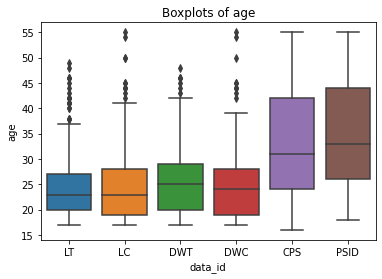

In [16]:
# Boxplots
sns.boxplot(x = 'data_id', y = 'age', data = df)
plt.title('Boxplots of age')
plt.show()

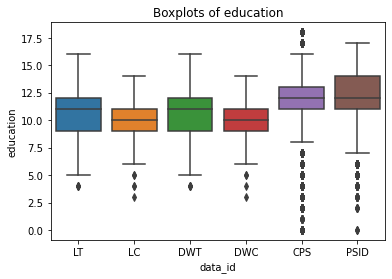

In [17]:
sns.boxplot(x = 'data_id', y = 'education', data = df)
plt.title('Boxplots of education')
plt.show()

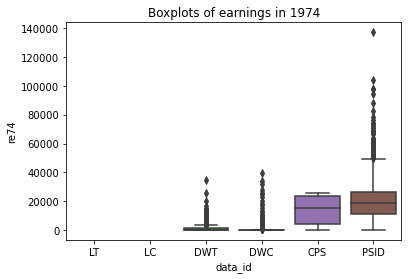

In [18]:
sns.boxplot(x = 'data_id', y = 're74', data = df)
plt.title('Boxplots of earnings in 1974')
plt.show()

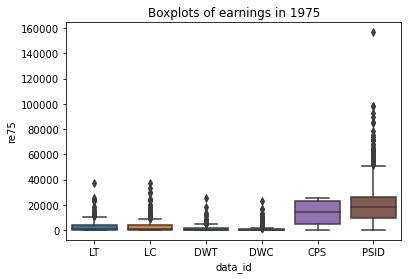

In [19]:
sns.boxplot(x = 'data_id', y = 're75', data = df)
plt.title('Boxplots of earnings in 1975')
plt.show()

The above boxplots show the distributions of pre-treatment continuous variables within each group. Again, it is obvious that the NSW samples are totally different from CPS/PSID in all the characteristics. In order to estimate the ATE from the nonexperimental data, we should take these differences into consideration.

## 3. Modeling

a. Analyze the data using 2-3 different model specifications (i.e. with/without covariates, using different definitions of the treatment, outcome, or predictor variables, etc.)  
Remember: complicated models are not necessarily better than simple models. There is nothing wrong with OLS regression if that’s the best model.

### 3.1 Regression

Under the assumption of unconfoundedness $Y_0, Y_1 \perp D | X$, we can obtain the average treatment effect by

$$
\begin{align*}
ATE &= E[Y_1 - Y_0] \\
    &= E_X[E[Y_1 - Y_0 | X]] \\
    &= E_X[E[Y_1|X] - E[Y_0 | X]] \\
    &= E_X[E[Y_1|X, D=1] - E[Y_0 | X, D=0]] \\
    &= E_X[E[Y|X, D=1] - E[Y|X, D=0]]. \\
\end{align*}
$$

In this section, we try to estimate $\mu_1 (X) \equiv E[Y | D = 1, X]$ and $\mu_0 (X) \equiv E[Y | D = 0, X]$ using different regression models: i) Linear regression, ii) Random Forest regression and iii) Gradient Boosting regression. 

#### 3.1.1 Linear Regression

Here, we assume $E[Y|D, X] = \alpha + \tau D + X \beta + u$. Then, we obtain $E[Y|D = 1, X] - E[Y|D = 0, X] = \tau$, which in turn implies $ATE = \tau$.

In [20]:
# Obtain a 'true' average treatment effects
Regression_result(outcome = 'dif', treat_id = 'LT', control_id = 'LC', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: LaLonde
Control: LaLonde


<class 'statsmodels.iolib.summary2.Summary'>
"""

=============================================================
               Without control    With age   With all control
-------------------------------------------------------------
treat          846.8883        856.9110      819.2771        
               (560.1417)      (557.6783)    (561.4912)      
age                            -703.6823***  -746.4430***    
                               (241.6312)    (251.1351)      
age2                           11.5827***    12.3287***      
                               (4.0793)      (4.2293)        
black                                        77.0276         
                                             (956.0357)      
education                                    87.1087         
                                             (217.5539)      
hispanic                                     977.7160        
                                             (1253.7689)     
nodegree                                     -469.8266       
                                             (891.0728)      
Intercept      2063.3655***    11841.9780*** 11732.1210***   
               (359.2589)      (3380.1524)   (4344.6938)     
R-squared      0.0032          0.0148        0.0176          
R-squared Adj. 0.0018          0.0107        0.0079          
=============================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

In [21]:
Regression_result(outcome = 're78', treat_id = 'LT', control_id = 'LC', df = df)

Dependent Variable: Earnings in 1978
Treatment: LaLonde
Control: LaLonde


<class 'statsmodels.iolib.summary2.Summary'>
"""

===========================================================
               Without control   With age  With all control
-----------------------------------------------------------
treat          886.3037*       881.7396*   798.3512*       
               (472.0863)      (472.6165)  (472.1283)      
age                            85.5222     -3.8055         
                               (204.7756)  (211.1663)      
age2                           -1.0738     0.5297          
                               (3.4571)    (3.5562)        
black                                      -1762.8326**    
                                           (803.8800)      
education                                  219.7946        
                                           (182.9296)      
hispanic                                   -117.1480       
                                           (1054.2282)     
nodegree                                   -494.2816       
                                           (749.2561)      
Intercept      5090.0483***    3687.5964   4430.1626       
               (302.7826)      (2864.5829) (3653.2238)     
R-squared      0.0049          0.0056      0.0238          
R-squared Adj. 0.0035          0.0014      0.0142          
===========================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

The coefficient on `treat` is the estimate for ATE. We can see that it is stable and around 800&ndash;900 when we use LaLonde's original dataset.

In [22]:
# Obtain a 'true' average treatment effects over the DW subset
Regression_result(outcome = 'dif', treat_id = 'DWT', control_id = 'DWC', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: Dehejia and Wahba
Control: Dehejia and Wahba


<class 'statsmodels.iolib.summary2.Summary'>
"""

===========================================================
               Without control   With age  With all control
-----------------------------------------------------------
treat          1529.1961**     1516.9969** 1375.1516**     
               (679.5380)      (682.2371)  (688.3945)      
age                            -46.6970    -182.7710       
                               (279.9331)  (288.1882)      
age2                           1.1926      3.4888          
                               (4.6231)    (4.7521)        
black                                      -1688.9039      
                                           (1260.7920)     
education                                  282.9176        
                                           (247.4508)      
hispanic                                   -71.1607        
                                           (1672.5122)     
nodegree                                   -828.7128       
                                           (1074.5320)     
Intercept      3287.8921***    3650.0468   4745.6828       
               (438.1468)      (3987.1196) (5052.0745)     
R-squared      0.0113          0.0120      0.0306          
R-squared Adj. 0.0091          0.0053      0.0151          
===========================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

In [23]:
Regression_result(outcome = 're78', treat_id = 'DWT', control_id = 'DWC', df = df)

Dependent Variable: Earnings in 1978
Treatment: Dehejia and Wahba
Control: Dehejia and Wahba


<class 'statsmodels.iolib.summary2.Summary'>
"""

============================================================
               Without control   With age   With all control
------------------------------------------------------------
treat          1794.3424***    1736.0577*** 1672.4265***    
               (632.8534)      (634.1201)   (637.3094)      
age                            294.9621     184.0301        
                               (260.1899)   (266.8021)      
age2                           -4.1564      -2.1640         
                               (4.2970)     (4.3995)        
black                                       -2208.0324*     
                                            (1167.2298)     
education                                   379.5027*       
                                            (229.0877)      
hispanic                                    128.4483        
                                            (1548.3967)     
nodegree                                    -101.6644       
                                            (994.7921)      
Intercept      4554.8011***    -19.9336     -521.8892       
               (408.0459)      (3705.9151)  (4677.1651)     
R-squared      0.0178          0.0224       0.0483          
R-squared Adj. 0.0156          0.0158       0.0331          
============================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

Notably, the ATE estimate is much larger than LaLonde's original data. It is about 1,300&ndash;1,800.

Now, we try to obtain these results using nonexperimental data. First, we compare LaLonde treatment dataset and CPS/PSID. If the unconfoundedness holds and our specification $E[Y|D, X] = \alpha + \tau D + X \beta + u$ is correct, we should be able to get similar results even when using CPS/PSID.

In [24]:
# Obtain nonexperimental treatment effects over LaLonde treatment and CPS
Regression_result(outcome = 'dif', treat_id = 'LT', control_id = 'CPS', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: LaLonde
Control: CPS


<class 'statsmodels.iolib.summary2.Summary'>
"""

=============================================================
               Without control    With age   With all control
-------------------------------------------------------------
treat          1714.3977***    195.1746      237.6512        
               (452.2939)      (441.8344)    (472.5252)      
age                            -561.3006***  -552.4132***    
                               (36.6097)     (37.9290)       
age2                           5.7530***     5.6575***       
                               (0.5158)      (0.5365)        
black                                        -183.2507       
                                             (225.2557)      
education                                    111.4728***     
                                             (30.5601)       
hispanic                                     -119.2571       
                                             (232.8084)      
nodegree                                     686.8576***     
                                             (189.7457)      
Intercept      1195.8561***    12792.5396*** 11092.4977***   
               (61.0734)       (600.9403)    (744.6135)      
R-squared      0.0009          0.0581        0.0591          
R-squared Adj. 0.0008          0.0579        0.0587          
=============================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

In [25]:
Regression_result(outcome = 're78', treat_id = 'LT', control_id = 'CPS', df = df)

Dependent Variable: Earnings in 1978
Treatment: LaLonde
Control: CPS


<class 'statsmodels.iolib.summary2.Summary'>
"""

==============================================================
               Without control    With age    With all control
--------------------------------------------------------------
treat          -8870.3076***   -7172.3080***  -4416.2116***   
               (562.4777)      (544.7287)     (577.0659)      
age                            1456.6580***   1300.4137***    
                               (45.1353)      (46.3204)       
age2                           -18.8343***    -16.4956***     
                               (0.6359)       (0.6552)        
black                                         -2617.0959***   
                                              (275.0909)      
education                                     194.3500***     
                                              (37.3211)       
hispanic                                      -1051.1493***   
                                              (284.3145)      
nodegree                                      -1165.7738***   
                                              (231.7247)      
Intercept      14846.6597***   -10462.0490*** -9862.3527***   
               (75.9515)       (740.8872)     (909.3507)      
R-squared      0.0150          0.0874         0.1055          
R-squared Adj. 0.0150          0.0872         0.1051          
==============================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

In [26]:
# Obtain nonexperimental treatment effects over LaLonde treatment and PSID
Regression_result(outcome = 'dif', treat_id = 'LT', control_id = 'PSID', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: LaLonde
Control: PSID


<class 'statsmodels.iolib.summary2.Summary'>
"""

===========================================================
               Without control   With age  With all control
-----------------------------------------------------------
treat          419.6706        -749.2072   -443.6768       
               (650.5836)      (691.9516)  (758.4989)      
age                            25.8463     -29.5044        
                               (154.1027)  (154.8596)      
age2                           -2.1310     -1.1350         
                               (2.1075)    (2.1258)        
black                                      -3.7683         
                                           (501.7495)      
education                                  342.0243***     
                                           (103.8807)      
hispanic                                   2309.8442**     
                                           (1061.4922)     
nodegree                                   591.6589        
                                           (655.8493)      
Intercept      2490.5833***    4410.2647*  622.0162        
               (212.3796)      (2636.9688) (2911.5944)     
R-squared      0.0001          0.0156      0.0227          
R-squared Adj. -0.0002         0.0145      0.0202          
===========================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

In [27]:
Regression_result(outcome = 're78', treat_id = 'LT', control_id = 'PSID', df = df)

Dependent Variable: Earnings in 1978
Treatment: LaLonde
Control: PSID


<class 'statsmodels.iolib.summary2.Summary'>
"""

==============================================================
               Without control    With age    With all control
--------------------------------------------------------------
treat          -15577.5689***  -13267.6571*** -8067.3221***   
               (913.3285)      (968.2475)     (990.4250)      
age                            1645.9811***   1219.2222***    
                               (215.6359)     (202.2110)      
age2                           -21.5892***    -14.2200***     
                               (2.9490)       (2.7758)        
black                                         -3204.3002***   
                                              (655.1693)      
education                                     1690.3607***    
                                              (135.6443)      
hispanic                                      902.7708        
                                              (1386.0644)     
nodegree                                      85.6125         
                                              (856.3882)      
Intercept      21553.9209***   -7235.5777**   -21850.5108***  
               (298.1513)      (3689.9088)    (3801.8719)     
R-squared      0.0946          0.1143         0.2343          
R-squared Adj. 0.0942          0.1134         0.2324          
==============================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

Compared to the true treatment effect of LaLonde's data, the treatment effects generated from nonexperimental data of CPS and PSID vary largely in different controlling conditions, and they fail to generate similar results to experimental data. Furthermore, the choice of the dependent variable greatly affects the results whereas we have got the similar results using experimental data.

In [28]:
# Obtain nonexperimental treatment effects over DW treat and CPS
Regression_result(outcome = 'dif', treat_id = 'DWT', control_id = 'CPS', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: Dehejia and Wahba
Control: CPS


<class 'statsmodels.iolib.summary2.Summary'>
"""

=============================================================
               Without control    With age   With all control
-------------------------------------------------------------
treat          3621.2321***    2383.3115***  2490.6260***    
               (570.7435)      (555.4471)    (582.8456)      
age                            -563.6571***  -555.5727***    
                               (36.6830)     (38.0107)       
age2                           5.7781***     5.6944***       
                               (0.5167)      (0.5375)        
black                                        -238.0458       
                                             (227.0879)      
education                                    112.5352***     
                                             (30.5870)       
hispanic                                     -80.9468        
                                             (233.9651)      
nodegree                                     682.6996***     
                                             (190.3127)      
Intercept      1195.8561***    12840.0933*** 11141.9591***   
               (61.0348)       (602.2814)    (746.1302)      
R-squared      0.0025          0.0603        0.0613          
R-squared Adj. 0.0024          0.0601        0.0609          
=============================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

In [29]:
Regression_result(outcome = 're78', treat_id = 'DWT', control_id = 'CPS', df = df)

Dependent Variable: Earnings in 1978
Treatment: Dehejia and Wahba
Control: CPS


<class 'statsmodels.iolib.summary2.Summary'>
"""

==============================================================
               Without control    With age    With all control
--------------------------------------------------------------
treat          -8497.5161***   -7274.3068***  -4416.8727***   
               (712.0207)      (686.8898)     (713.9476)      
age                            1469.5387***   1312.1177***    
                               (45.3637)      (46.5606)       
age2                           -19.0058***    -16.6517***     
                               (0.6389)       (0.6584)        
black                                         -2636.4046***   
                                              (278.1678)      
education                                     192.1381***     
                                              (37.4671)       
hispanic                                      -1059.5644***   
                                              (286.5919)      
nodegree                                      -1182.8995***   
                                              (233.1206)      
Intercept      14846.6597***   -10679.8537*** -10026.1636***  
               (76.1429)       (744.8072)     (913.9605)      
R-squared      0.0087          0.0824         0.1006          
R-squared Adj. 0.0087          0.0822         0.1003          
==============================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

In [30]:
# Obtain nonexperimental treatment effects over DW treat and PSID
Regression_result(outcome = 'dif', treat_id = 'DWT', control_id = 'PSID', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: Dehejia and Wahba
Control: PSID


<class 'statsmodels.iolib.summary2.Summary'>
"""

===========================================================
               Without control   With age  With all control
-----------------------------------------------------------
treat          2326.5049***    1256.9279   1724.2845*      
               (813.8592)      (834.9623)  (891.7198)      
age                            35.4167     -28.6133        
                               (160.2060)  (160.8147)      
age2                           -2.2925     -1.1832         
                               (2.1851)    (2.2009)        
black                                      -125.3197       
                                           (514.0388)      
education                                  345.0581***     
                                           (105.9095)      
hispanic                                   3020.3991***    
                                           (1144.0036)     
nodegree                                   572.2747        
                                           (677.9455)      
Intercept      2490.5833***    4290.4379   631.1857        
               (214.0293)      (2746.0209) (3006.7413)     
R-squared      0.0030          0.0193      0.0277          
R-squared Adj. 0.0027          0.0182      0.0252          
===========================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

In [31]:
Regression_result(outcome = 're78', treat_id = 'DWT', control_id = 'PSID', df = df)

Dependent Variable: Earnings in 1978
Treatment: Dehejia and Wahba
Control: PSID


<class 'statsmodels.iolib.summary2.Summary'>
"""

==============================================================
               Without control    With age    With all control
--------------------------------------------------------------
treat          -15204.7774***  -13268.9504*** -7741.0751***   
               (1154.6143)     (1179.8389)    (1175.2733)     
age                            1786.3889***   1342.7859***    
                               (226.3782)     (211.9514)      
age2                           -23.4322***    -15.8253***     
                               (3.0876)       (2.9008)        
black                                         -3240.1830***   
                                              (677.4955)      
education                                     1677.2571***    
                                              (139.5871)      
hispanic                                      1149.6935       
                                              (1507.7796)     
nodegree                                      -161.6883       
                                              (893.5220)      
Intercept      21553.9209***   -9689.5607**   -23796.8587***  
               (303.6414)      (3880.2499)    (3962.8398)     
R-squared      0.0609          0.0836         0.2096          
R-squared Adj. 0.0606          0.0825         0.2075          
==============================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

Similarly, the treatment effects from nonexperiment data fail to generate similar results of DW's experiment results. Also, the dependent variable matters for the estimation of ATE.

Here we conclude that linear regression fails to generate experimental results by nonexperimental data. That is possibly because (i) unconfoundedness fails to hold or (ii) a linear specification is wrong. We will apply other regression methods to see if (ii) is true. Note that unconfoundedness is not testable.

#### 3.1.2 Random Forest Regression

Now we estimate $\mu_d (X = x) = f(d, x)$ by Random Forest. First, we fit $Y = f(D, X)$ by Random Forest and get the estimator $\hat{f}(D, X)$. Then, the ATE estimate is given by the sample average of $\hat{f}(1, X) - \hat{f}(0, X)$.

It is well known that the Random Forest often performs well for prediction. The Random Forest can predict the non-linear relationship between dependent and independent variables, so we expect that it can potentially give us nonexperimental estimates that are closer to experimental ones. The hyperparameters are tuned by cross validation.

In [32]:
param_grid = {'n_estimators': [50, 100, 500, 1000],
              'max_features': [2, 3, 4, 5]}

fn_RF_results(df = df, param_grid = param_grid)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [19:07<00:00, 382.65s/it]


Experiment          CPS         PSID
LaLonde dif   1050.745880  2693.495601   980.549533
LaLonde re78   947.432929 -3478.371177 -8515.034604
DW dif        1265.715325  4150.986449  1958.355692
DW re78       1493.852760 -2824.935857 -7013.979999

#### 3.1.3 Gradient Boosting Regression
Estimate $\mu_d (X) \equiv E[Y|D = d, X]$ by Gradient Boosting.

In [45]:
param_grid = {'n_estimators': [50, 100, 500, 1000],
              'max_features': [2, 3, 4, 5]}

fn_GB_results(df = df, param_grid = param_grid)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:57<00:00, 119.07s/it]


Experiment          CPS          PSID
LaLonde dif    748.908045  2134.017578    803.998660
LaLonde re78   737.185954 -4556.254399 -10018.016550
DW dif        1173.750017  4152.882589   2891.013934
DW re78       1394.727095 -4170.629539  -7900.470350

### 3.2 Propensity Score Matching

#### 3.2.1 Estimate propensity score by logit regression

# Testing code for matching caliper

In [51]:
df1 = fn_generate_data(treat_id = 'LT', control_id = 'CPS', df = df)
X, T, Y = fn_generate_variables(data = df1, outcome = 'dif')
pipe = Pipeline([('scaler', StandardScaler()),('logistic_classifier', lr())])
pipe.fit(X, T.ravel())
phat = np.array(pipe.predict_proba(X)[:,1], ndmin = 2).T
df_prop = fn_generate_df_prop(df = df1, prop = phat, truncate_level = 0.01)

In [52]:
def fn_generate_df_matched(df, outcome, n_neighbors = 1):
    
    caliper = np.std(df.propensity_score) * 0.25
    knn1 = NearestNeighbors(n_neighbors = n_neighbors, radius=caliper)
    knn0 = NearestNeighbors(n_neighbors = n_neighbors, radius=caliper)
    
    df_treat = df[df.treat == 1]
    df_contr = df[df.treat == 0]
    
    index1 = df_treat.index.to_numpy().reshape(-1,1)
    X1 = df_treat[['propensity_score_logit']].to_numpy()
    y1 = df_treat[[outcome]].to_numpy()
    knn1.fit(X1)
    
    index0 = df_contr.index.to_numpy().reshape(-1,1)
    X0 = df_contr[['propensity_score_logit']].to_numpy()
    y0 = df_contr[[outcome]].to_numpy()
    knn0.fit(X0)
    
    matched_index = np.zeros((len(df), n_neighbors))
    matched_outcome = np.zeros((len(df), n_neighbors))
    
    for i in range(len(df)):
        
        if df.treat[i] == 0:
            where = knn1.kneighbors([[df['propensity_score_logit'][i]]],
                                    n_neighbors = n_neighbors, return_distance = False).ravel()
            index = index1[where]
            outcome = y1[where]
            
        elif df.treat[i] == 1:
            where = knn0.kneighbors([[df['propensity_score_logit'][i]]],
                                    n_neighbors = n_neighbors, return_distance = False).ravel()
            index = index0[where]
            outcome = y0[where]
        
        matched_index[i, :] = index.ravel()
        matched_outcome[i, :] = outcome.ravel()
        
    df_matched_index = pd.DataFrame(matched_index)
    df_matched_outcome = pd.DataFrame(matched_outcome)
    
    df_matched = pd.concat([df_matched_index, df_matched_outcome], axis = 1)
    
    colnames = []
    
    for i in range(n_neighbors):
        colnames += ['matched_index_' + str(i + 1)]

    for i in range(n_neighbors):
        colnames += ['matched_outcome_' + str(i + 1)]
    
    df_matched.columns = colnames
        
    df_output = pd.concat([df, df_matched], axis=1)
    
    return df_output

In [53]:
df_matched = fn_generate_df_matched(df = df_prop, outcome = 'dif', n_neighbors = 1)
df_matched

data_id  treat   age  education  black  hispanic  married  nodegree  \
0         LT    1.0  37.0       11.0    1.0       0.0      1.0       1.0   
1         LT    1.0  22.0        9.0    0.0       1.0      0.0       1.0   
2         LT    1.0  30.0       12.0    1.0       0.0      0.0       0.0   
3         LT    1.0  27.0       11.0    1.0       0.0      0.0       1.0   
4         LT    1.0  33.0        8.0    1.0       0.0      0.0       1.0   
...      ...    ...   ...        ...    ...       ...      ...       ...   
2645     CPS    0.0  32.0        5.0    1.0       0.0      1.0       1.0   
2646     CPS    0.0  16.0        9.0    0.0       0.0      0.0       1.0   
2647     CPS    0.0  22.0       14.0    0.0       1.0      0.0       0.0   
2648     CPS    0.0  22.0       12.0    1.0       0.0      0.0       0.0   
2649     CPS    0.0  20.0       12.0    1.0       0.0      1.0       0.0   

              re75          re78           dif  propensity_score  \
0         0.000000   9930.045898   9930.045898          0.211110   
1         0.000000   3595.894043   3595.894043          0.136097   
2         0.000000  24909.449219  24909.449219          0.246694   
3         0.000000   7506.145996   7506.145996          0.536984   
4         0.000000    289.789886    289.789886          0.456374   
...            ...           ...           ...               ...   
2645      0.000000    187.671295    187.671295          0.171760   
2646      0.000000   1495.458984   1495.458984          0.020603   
2647   5281.452148   6014.347168    732.895020          0.032251   
2648   6801.435059   2757.437988  -4043.997070          0.153068   
2649  11832.240234   6895.071777  -4937.168457          0.029979   

      propensity_score_logit  matched_index_1  matched_outcome_1  
0                  -1.318247           2045.0        8876.758057  
1                  -1.848089           1236.0        2611.256226  
2                  -1.116323            531.0        1898.879028  
3                   0.148206            909.0        7919.249878  
4                  -0.174949           2539.0        3695.935547  
...                      ...              ...                ...  
2645               -1.573207            218.0        3665.239258  
2646               -3.861480             59.0        1048.432007  
2647               -3.401432            270.0       25110.378906  
2648               -1.710739             38.0        3094.156006  
2649               -3.476836            241.0      -14189.522461  

[2650 rows x 15 columns]

In [54]:
df_matched[df_matched.treat == 1]['dif'].mean() - df_matched[df_matched.treat == 1]['matched_outcome_1'].mean()

-427.86982808646735

In [55]:
df_matched = fn_generate_df_matched(df = df_prop, outcome = 'dif', n_neighbors = 10)
df_matched

data_id  treat   age  education  black  hispanic  married  nodegree  \
0         LT    1.0  37.0       11.0    1.0       0.0      1.0       1.0   
1         LT    1.0  22.0        9.0    0.0       1.0      0.0       1.0   
2         LT    1.0  30.0       12.0    1.0       0.0      0.0       0.0   
3         LT    1.0  27.0       11.0    1.0       0.0      0.0       1.0   
4         LT    1.0  33.0        8.0    1.0       0.0      0.0       1.0   
...      ...    ...   ...        ...    ...       ...      ...       ...   
2645     CPS    0.0  32.0        5.0    1.0       0.0      1.0       1.0   
2646     CPS    0.0  16.0        9.0    0.0       0.0      0.0       1.0   
2647     CPS    0.0  22.0       14.0    0.0       1.0      0.0       0.0   
2648     CPS    0.0  22.0       12.0    1.0       0.0      0.0       0.0   
2649     CPS    0.0  20.0       12.0    1.0       0.0      1.0       0.0   

              re75          re78  ...  matched_outcome_1  matched_outcome_2  \
0         0.000000   9930.045898  ...        8876.758057       -3043.548096   
1         0.000000   3595.894043  ...        2611.256226        3218.630371   
2         0.000000  24909.449219  ...        1898.879028        1161.493042   
3         0.000000   7506.145996  ...        7919.249878        -451.161285   
4         0.000000    289.789886  ...        3695.935547        1556.045898   
...            ...           ...  ...                ...                ...   
2645      0.000000    187.671295  ...        3665.239258       -5204.258789   
2646      0.000000   1495.458984  ...        1048.432007        3402.147156   
2647   5281.452148   6014.347168  ...       25110.378906      -14189.522461   
2648   6801.435059   2757.437988  ...        3094.156006        6136.326469   
2649  11832.240234   6895.071777  ...      -14189.522461        1324.659668   

      matched_outcome_3  matched_outcome_4  matched_outcome_5  \
0          21176.588867       -5733.722168        5856.259766   
1              0.000000        4676.322266        3919.890625   
2           6762.107422       16833.356934       -3242.273926   
3           -519.932495       11594.666382         278.011597   
4          -2306.532104       -2846.613037       -4273.500000   
...                 ...                ...                ...   
2645       -4078.152100       -4310.455078      -10044.493652   
2646       -4796.459961       13188.830078       18783.349609   
2647        1324.659668       -5028.802246      -12625.509766   
2648        7639.616211       -4792.584091        6097.572754   
2649       25110.378906        5011.250000      -16003.164062   

      matched_outcome_6  matched_outcome_7  matched_outcome_8  \
0           5054.507080       19248.613770       11968.333496   
1           5464.973877        1413.502930        8199.933105   
2          24360.320312        7044.323242       -6006.532227   
3           3723.899109        5939.978134       15315.412720   
4           -234.787720        4344.032959        -672.564941   
...                 ...                ...                ...   
2645        6097.572754       -6561.526855        7639.616211   
2646       10466.012329       -2791.800781      -16003.164062   
2647        5011.250000      -16003.164062        -557.995789   
2648        -797.038086      -10044.493652       -5204.258789   
2649       -2791.800781       -5028.802246      -12625.509766   

      matched_outcome_9  matched_outcome_10  
0              0.000000        -3752.516113  
1           1911.552979         7515.716797  
2           1472.009766         -707.177429  
3          -1099.258057         7618.562134  
4           3376.377930        11470.822021  
...                 ...                 ...  
2645        3094.156006         7132.242188  
2646        5011.250000         4392.870972  
2647      -18154.060547         2787.959961  
2648        3665.239258         7284.985840  
2649        1048.432007         -557.995789  

[2650 rows x 33 columns]

In [56]:
n_neighbors = 10
colnames = []
for i in range(1, n_neighbors+1):
    colnames += ['matched_outcome_' + str(i)]
    tauhats = df_matched[df_matched.treat == 1]['dif'] - df_matched[df_matched.treat == 1][colnames].mean(axis = 1)
np.mean(tauhats)

-313.70646271826166

# End of testing for Caliper

In [57]:
# Firstly, we will use Lalonde dataset with propensity score matching estimation, where propensity score is estimated by logit regression
np.random.seed(10)
LA_results = {}
LA_prop = {}

control_names = ['CPS','PSID']
method = 'logit'
n_neighbors = 1

for control in control_names:
    names = 'LT_' + str(control)
    treat, df_prop = propensity_score_matching(df, treat_id = 'LT', control_id = control, method = method, n_neighbors = n_neighbors)
    LA_results[names] = {'treatment effect': treat}
    LA_prop[names] = {'df_prop': df_prop}
LA_results.items()                       

dict_items([('LT_CPS', {'treatment effect': -427.86982808646735}), ('LT_PSID', {'treatment effect': -209.21632963946104})])

The treatment effect becomes negative with logit regression to estimate the propensity score!

In [58]:
# Then, we will use DW dataset 
np.random.seed(10)
DW_results = {}
DW_prop = {}

control_names = ['CPS','PSID']
method = 'logit'
n_neighbors = 1

for control in control_names:
    names = 'DWT_' + str(control)
    treat, df_prop = propensity_score_matching(df, treat_id = 'DWT', control_id = control, method = method, n_neighbors = n_neighbors)
    DW_results[names] = {'treatment effect': treat}
    DW_prop[names] = {'df_prop': df_prop}

DW_results.items()    

dict_items([('DWT_CPS', {'treatment effect': 847.6586335690436}), ('DWT_PSID', {'treatment effect': -324.860459174899})])

#### 3.2.2 Estimate propensity score by random forest

In [59]:
# Secondly, we will use Lalonde dataset with propensity score matching estimation, where propensity score is estimated by random forest
np.random.seed(10)
LA_results = {}
LA_prop = {}

control_names = ['CPS','PSID']
method = 'Random Forest'
n_neighbors = 1

for control in control_names:
    names = 'LT_' + str(control)
    treat, df_prop = propensity_score_matching(df, treat_id = 'LT', control_id = control, method = method, n_neighbors = n_neighbors)
    LA_results[names] = {'treatment effect': treat}
    LA_prop[names] = {'df_prop': df_prop}
LA_results.items() 

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits


dict_items([('LT_CPS', {'treatment effect': 2490.205081515842}), ('LT_PSID', {'treatment effect': 1421.7309123742534})])

In [60]:
# Then, we will use DW dataset 
np.random.seed(10)
DW_results = {}
DW_prop = {}

control_names = ['CPS','PSID']
method = 'Random Forest'
n_neighbors = 1

for control in control_names:
    names = 'DWT_' + str(control)
    treat, df_prop = propensity_score_matching(df, treat_id = 'DWT', control_id = control, method = method, n_neighbors = n_neighbors)
    DW_results[names] = {'treatment effect': treat}
    DW_prop[names] = {'df_prop': df_prop}

DW_results.items()  

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits


dict_items([('DWT_CPS', {'treatment effect': 3446.9734947668258}), ('DWT_PSID', {'treatment effect': 3662.3931191637625})])

Much larger than the experimental data.

### 3.3 Inverse Probability of Treatment Weighted (IPTW) Estimator

In [61]:
# Firstly, we will use Lalonde dataset with IPTW estimation
for names, results in LA_prop.items():
    ATE = fn_IPTW(df = results['df_prop'], outcome = 'dif')
    print(names, "treatment effect =", ATE)

LT_CPS treatment effect = -1075.4987488478077
LT_PSID treatment effect = -1983.609643002712


In [62]:
# Secondly, we will use Lalonde dataset with IPTW estimation
for names, results in DW_prop.items():
    ATE = fn_IPTW(df = results['df_prop'], outcome = 'dif')
    print(names, "treatment effect =", ATE)

DWT_CPS treatment effect = -1346.6291405628722
DWT_PSID treatment effect = -1645.4456571762307


### 3.4 Doubly Robust Estimator

In [63]:
# Firstly, we will use Lalonde dataset with Doubly Robust estimation
for names, results in LA_prop.items():
    ATE = fn_doubly_robust(df = results['df_prop'], outcome = 'dif')
    print(names, "treatment effect =", ATE)

LT_CPS treatment effect = 312.5557378373228
LT_PSID treatment effect = -736.0474371197965


In [64]:
# Secondly, we will use Lalonde dataset with IPTW estimation
for names, results in DW_prop.items():
    ATE = fn_doubly_robust(df = results['df_prop'], outcome = 'dif')
    print(names, "treatment effect =", ATE)

DWT_CPS treatment effect = 2002.347837833241
DWT_PSID treatment effect = 774.4440537549544


## 4. Findings

a. What are your main findings?  
b. Are your findings robust to different model specifications?

## 5. Conclusion

a. Discuss what we’ve learned from your analysis.  
b. Discuss any questions that could be answered in the future.

## Endnotes

<a name="cite_note-1"></a>1. [^](#cite_ref-1) Aid to Families with Dependent Children.

## References

1. Dehejia, R., & Wahba, S. (1999). Causal effects in nonexperimental studies: Reevaluating the evaluation of training programs. *Journal of the American Statistical Association*, 94(448), 1053&ndash;1062.  
2. Dehejia, R., & Wahba, S. (2002). Propensity score-matching methods for nonexperimental causal studies. *Review of Economics and Statistics*, 84(1), 151&ndash;161.  
3. LaLonde, R. (1986). Evaluating the econometric evaluations of training programs with experimental data. *American Economic Review*, 76(4), 604&ndash;620.  
4. Smith, J. A., & Todd, P. E. (2005). Does matching overcome LaLonde’s critique of nonexperimental estimators? *Journal of Econometrics*, 125(1–2), 305&ndash;353.  